# Traffic Analysis - Roetersstraat, Amsterdam
- Dataset was provided by our Partner Klaas 
- Dataset is dat collected by two telraam sensors (camera sensors) on Roeterstraat (https://telraam.net/nl/location/9000009380)
## Who's on the Street ? 
---


In [2]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('raw_data.csv')
df['Date and Time (Local)'] = pd.to_datetime(df['Date and Time (Local)'])

# Calculate totals
total_pedestrians = df['Pedestrian Total'].sum()
total_bikes = df['Bike Total'].sum()
total_cars = df['Car Total'].sum()
total_all = total_pedestrians + total_bikes + total_cars

# Print percentages
print("Who's on the Street?\n")
print(f"Pedestrians: {total_pedestrians:,} ({total_pedestrians/total_all*100:.1f}%)")
print(f"Bikes: {total_bikes:,} ({total_bikes/total_all*100:.1f}%)")
print(f"Cars: {total_cars:,} ({total_cars/total_all*100:.1f}%)")

Who's on the Street?

Pedestrians: 266,525 (42.0%)
Bikes: 222,997 (35.1%)
Cars: 145,555 (22.9%)


- mostly pedestrians on the street --> transforming into LTN is not such a bad idea 

## Who's Driving Above 30 km/h?
---
- Streets speedlimit is 30m/h



In [3]:
# Calculate vehicles under and over 30 km/h
speed_columns = [
    'Speed Car 0-10 km/h (%)', 'Speed Car 10-20 km/h (%)', 'Speed Car 20-30 km/h (%)',
    'Speed Car 30-40 km/h (%)', 'Speed Car 40-50 km/h (%)', 'Speed Car 50-60 km/h (%)',
    'Speed Car 60-70 km/h (%)', 'Speed Car 70+ km/h (%)'
]

# Calculate counts for each speed range
for col in speed_columns:
    speed_range = col.replace('Speed Car ', '').replace(' (%)', '')
    df[f'Count {speed_range}'] = (df[col] / 100) * df['Car Total']

# Calculate under and over 30 km/h
df['Under 30 km/h'] = df['Count 0-10 km/h'] + df['Count 10-20 km/h'] + df['Count 20-30 km/h']
df['Over 30 km/h'] = (df['Count 30-40 km/h'] + df['Count 40-50 km/h'] + 
                       df['Count 50-60 km/h'] + df['Count 60-70 km/h'] + df['Count 70+ km/h'])

# Remove NaN values
df_speed = df.dropna(subset=['Over 30 km/h'])

total_under = df_speed['Under 30 km/h'].sum()
total_over = df_speed['Over 30 km/h'].sum()
total_vehicles = total_under + total_over

# Print percentages
print("Speed Analysis: Over vs Under 30 km/h\n")
print(f"Vehicles under 30 km/h: {int(total_under):,} ({total_under/total_vehicles*100:.1f}%)")
print(f"Vehicles over 30 km/h: {int(total_over):,} ({total_over/total_vehicles*100:.1f}%)")

Speed Analysis: Over vs Under 30 km/h

Vehicles under 30 km/h: 67,969 (46.7%)
Vehicles over 30 km/h: 77,584 (53.3%)


- more than half drive faster than the speedlimit 
--> speedlimit needs to be enforced more 

- safety hazard 

## Traffic Patterns at Different Times of Day
---

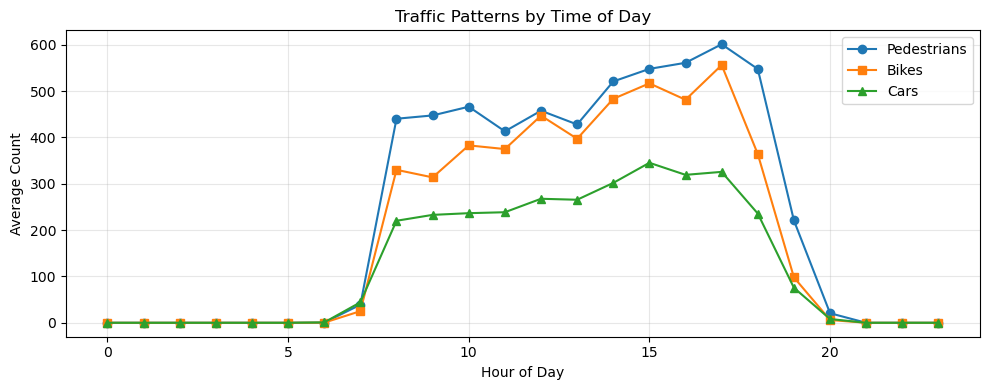

Peak hour for Pedestrians: 17:00
Peak hour for Bikes: 17:00
Peak hour for Cars: 15:00


In [4]:
import matplotlib.pyplot as plt

# Extract hour from datetime
df['Hour'] = df['Date and Time (Local)'].dt.hour

# Calculate average traffic by hour
hourly_avg = df.groupby('Hour')[['Pedestrian Total', 'Bike Total', 'Car Total']].mean()

# Create simple visualization
plt.figure(figsize=(10, 4))
plt.plot(hourly_avg.index, hourly_avg['Pedestrian Total'], label='Pedestrians', marker='o')
plt.plot(hourly_avg.index, hourly_avg['Bike Total'], label='Bikes', marker='s')
plt.plot(hourly_avg.index, hourly_avg['Car Total'], label='Cars', marker='^')
plt.xlabel('Hour of Day')
plt.ylabel('Average Count')
plt.title('Traffic Patterns by Time of Day')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find and print peak hours
peak_pedestrians = hourly_avg['Pedestrian Total'].idxmax()
peak_bikes = hourly_avg['Bike Total'].idxmax()
peak_cars = hourly_avg['Car Total'].idxmax()

print(f"Peak hour for Pedestrians: {peak_pedestrians}:00")
print(f"Peak hour for Bikes: {peak_bikes}:00")
print(f"Peak hour for Cars: {peak_cars}:00")

### Sensor does not pick up who exactly uses the street during 9pm - 6am (just one "Nightime" category) !!
- Remove those values as they are irrelevant
- also remove values where --> uptime = poor 

In [15]:
df['Date and Time (Local)'] = pd.to_datetime(df['Date and Time (Local)'])

df_filtered = df[(df['Date and Time (Local)'].dt.hour > 6) & (df['Date and Time (Local)'].dt.hour < 21)]
df_filtered = df_filtered[df_filtered['Uptime'] != 'Poor uptime - 0.5']
df_filtered = df_filtered.drop(['Night Total', 'Hour'], axis=1)

# Save to new CSV file
df_filtered.to_csv('filtered_traffic_data.csv', index=False)

print(f"Original data: {len(df)} rows")
print(f"Filtered data: {len(df_filtered)} rows")
print(f"Removed: {len(df) - len(df_filtered)} rows")

Original data: 1121 rows
Filtered data: 651 rows
Removed: 470 rows


## Sidewalk size 
---
- public dataset by gemeente(https://maps.amsterdam.nl/open_geodata/)
- comparing average Amsterdam side walk size with Roetersstraat in regards to safety (?)

In [ ]:
sidewalk_df = pd.read_csv('SIDEWALKS.csv', sep=';')

#Filter out "Nog onbepaald" (not determined)
sidewalk_df = sidewalk_df[sidewalk_df['ComfortLevel'] != 'Nog onbepaald']

sidewalk_df['ComfortLevel_numeric'] = (sidewalk_df['ComfortLevel']
    .str.replace('m', '', regex=False)
    .str.replace('Smaller dan ', '', regex=False)
    .str.replace('Saller dan ', '', regex=False)
    .str.replace(' of breder', '', regex=False)
    .astype(float))

#Average per street
street_avg = sidewalk_df.groupby('Streetname')['ComfortLevel_numeric'].mean()

#Overall average
overall_avg = sidewalk_df['ComfortLevel_numeric'].mean()
print(f"Overall Average Sidewalk width: {overall_avg:.2f}m")

#Roetersstraat average
roetersstraat_avg = sidewalk_df[sidewalk_df['Streetname'] == 'Roetersstraat']['ComfortLevel_numeric'].mean()
print(f"Roetersstraat Average Sidewalk width: {roetersstraat_avg:.2f}m")


Overall Average Sidewalk width: 1.90m
Roetersstraat Average Sidewalk width: 1.39m


- Roetersstraat average sidewalk width is smaller than the overall sidewalk width in Amsterdam, although mostly pedestrians use the street 

## Speed Distribution Roetersstraat 
---


In [31]:
traffic_df = pd.read_csv('filtered_traffic_data.csv')

# Calculate speed distribution from actual traffic data
speed_cols = ['Speed Car 0-10 km/h (%)', 'Speed Car 10-20 km/h (%)', 'Speed Car 20-30 km/h (%)',
              'Speed Car 30-40 km/h (%)', 'Speed Car 40-50 km/h (%)', 'Speed Car 50-60 km/h (%)',
              'Speed Car 60-70 km/h (%)', 'Speed Car 70+ km/h (%)']

# Average percentage across all observations
speed_dist = traffic_df[speed_cols].mean()
speed_ranges = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70+']

average_speeds = {}

print("Speed Distribution on Roetersstraat:\n")
for speed_range, percentage in zip(speed_ranges, speed_dist):
    if percentage >= 10.0:
        average_speeds[speed_range] = percentage
        print(f"{speed_range} km/h: {percentage:.1f}%")


Speed Distribution on Roetersstraat:

10-20 km/h: 12.6%
20-30 km/h: 23.0%
30-40 km/h: 24.0%
40-50 km/h: 12.3%


## Noise Pollution
---


- Uses a simplified logarithmic noise model based on vehicle count, speed, and vehicle type

- Random Forest Training: Trains 100 decision trees on the CNOSSOS-EU calculations to learn complex patterns between traffic conditions and noise levels, using 80% of data for training and 20% for validation

- Speed-Based Predictions: The trained model predicts noise levels for the average speeds distribution 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.w

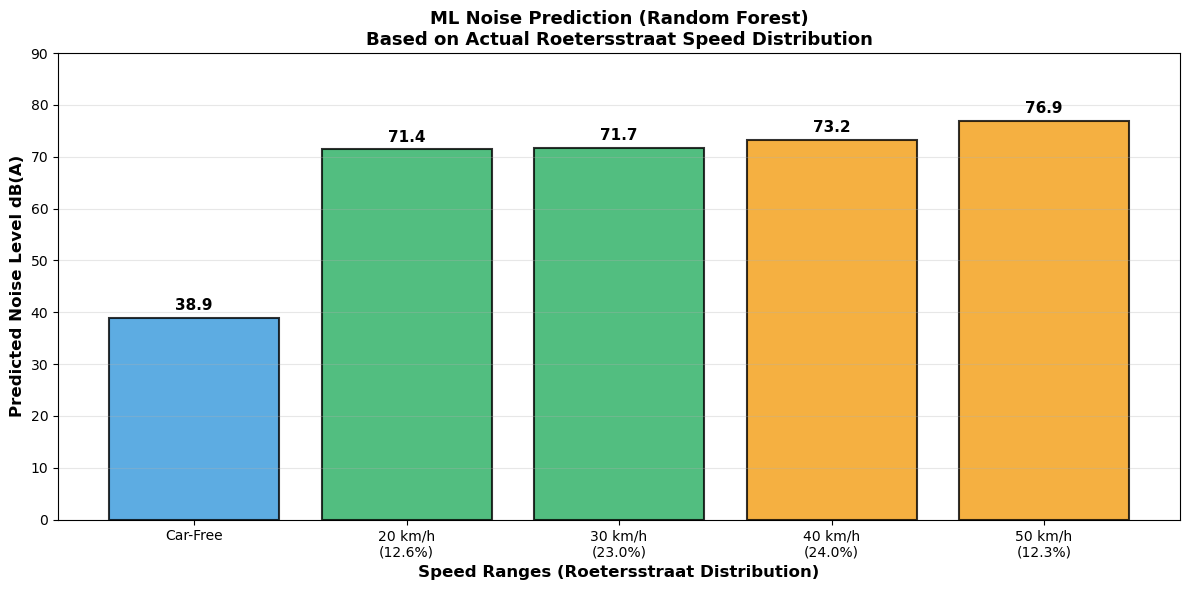

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

df = pd.read_csv('filtered_traffic_data.csv')

# CNOSSOS-EU formula (official EU noise model)
def calculate_noise_cnossos(speed, cars, heavy):
    L_light = 10 * np.log10(cars + 0.1) + 33 * np.log10(speed / 70) + 54.2
    L_heavy = 10 * np.log10(heavy + 0.1) + 33 * np.log10(speed / 70) + 61.5
    return 10 * np.log10(10**(L_light/10) + 10**(L_heavy/10))

# Create training labels
df['noise_db'] = df.apply(lambda row: calculate_noise_cnossos(
    row['Speed V85 km/h'], row['Car Total'], row['Large vehicle Total']), axis=1)

# Train Random Forest model
X = df[['Speed V85 km/h', 'Car Total', 'Large vehicle Total']].dropna()
y = df.loc[X.index, 'noise_db']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
model.fit(X_train, y_train)

# Use actual Roetersstraat speed distribution
avg_cars = df['Car Total'].mean()
avg_heavy = df['Large vehicle Total'].mean()

# Extract speeds and percentages from average_speeds dictionary
speeds = [int(s.split('-')[1]) for s in average_speeds.keys()]  # Get upper bound of each range
percentages = list(average_speeds.values())

# Predictions
car_free_pred = model.predict([[20, 0, 0]])[0]
speed_predictions = [model.predict([[s, avg_cars, avg_heavy]])[0] for s in speeds]

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))

labels = ['Car-Free'] + [f'{s} km/h\n({p:.1f}%)' for s, p in zip(speeds, percentages)]
noise_levels = [car_free_pred] + speed_predictions
colors = ['#3498db'] + ['#27ae60' if s <= 30 else '#f39c12' if s <= 50 else '#e74c3c' for s in speeds]

bars = ax.bar(labels, noise_levels, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_ylabel('Predicted Noise Level dB(A)', fontsize=12, fontweight='bold')
ax.set_xlabel('Speed Ranges (Roetersstraat Distribution)', fontsize=12, fontweight='bold')
ax.set_title('ML Noise Prediction (Random Forest)\nBased on Actual Roetersstraat Speed Distribution', fontsize=13, fontweight='bold')
ax.set_ylim(0, 90)
ax.grid(axis='y', alpha=0.3)

for bar, noise in zip(bars, noise_levels):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5, 
            f'{noise:.1f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

- noise level would be reduced by a lot, if transformed into LTN

- enforcing the speed limit would also decrease noise levels 

## London casualties
---

- filtered by Hackney --> most LTNs there

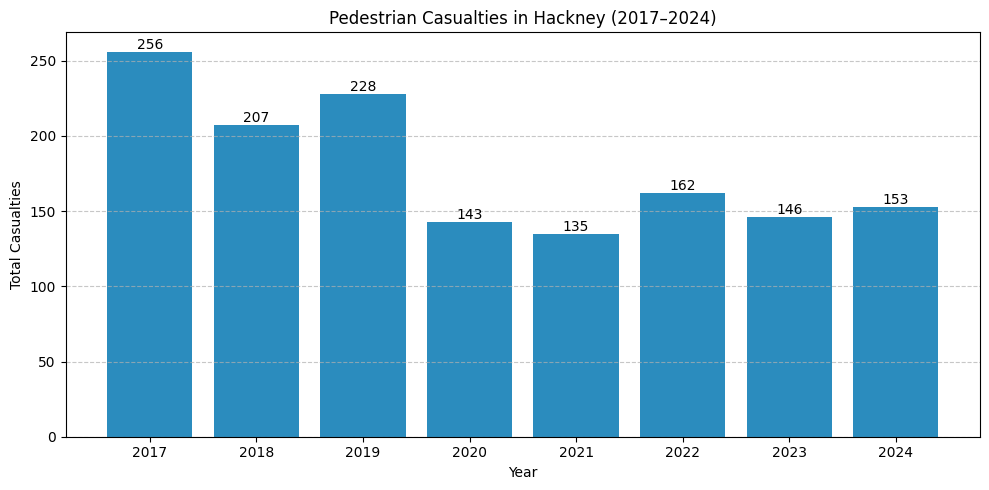


Pedestrian casualties in Hackney (2017–2024):
   Year  Casualties
0  2017         256
1  2018         207
2  2019         228
3  2020         143
4  2021         135
5  2022         162
6  2023         146
7  2024         153


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

excel_path = "casualties.xlsx"

# FIX 1: The correct header is at index 3 (Row 4 in Excel)
table12 = pd.read_excel(excel_path, sheet_name="Table 12", header=3)

# Normalize column names
table12.columns = [str(c).strip() for c in table12.columns]

# Helper to find columns
def find_col_by_keywords(cols, keywords):
    for c in cols:
        if all(k.lower() in c.lower() for k in keywords):
            return c
    return None

# Identify key columns
borough_col = find_col_by_keywords(table12.columns, ['borough'])
cas_mode_col = find_col_by_keywords(table12.columns, ['mode'])
severity_col = find_col_by_keywords(table12.columns, ['severity'])

if not all([borough_col, cas_mode_col, severity_col]):
    print("Could not find all required columns.")
    print("Available columns:", table12.columns.tolist())
else:
    # FIX 2: Filter for 'Total' severity to avoid summing Fatal + Serious + Slight + Total (double counting)
    mask = (
        (table12[borough_col].astype(str).str.strip().str.lower() == 'hackney') &
        (table12[cas_mode_col].astype(str).str.strip().str.lower() == 'pedestrian') &
        (table12[severity_col].astype(str).str.strip().str.lower() == 'total')
    )
    
    hackney_ped = table12[mask]

    if hackney_ped.empty:
        print("No matching rows found.")
    else:
        # Years 2017 to 2024
        years = [str(y) for y in range(2017, 2025)]
        
        values = []
        for y in years:
            # Find column that contains the year (e.g., "2017 casualty count")
            col_match = next((c for c in table12.columns if y in c), None)
            
            if col_match:
                val = pd.to_numeric(hackney_ped[col_match], errors='coerce').fillna(0).sum()
                values.append(int(val))
            else:
                values.append(0)
                print(f"Warning: Column for year {y} not found.")

        # Plotting
        plt.figure(figsize=(10, 5))
        bars = plt.bar(years, values, color="#2b8cbe")
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height}',
                     ha='center', va='bottom')

        plt.title("Pedestrian Casualties in Hackney (2017–2024)")
        plt.xlabel("Year")
        plt.ylabel("Total Casualties")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        print('\nPedestrian casualties in Hackney (2017–2024):')
        print(pd.DataFrame({'Year': years, 'Casualties': values}))

